<a href="https://colab.research.google.com/github/ditatteda/ML21_HW/blob/ditatteda_branch/HW02/ML21_HW02-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phoneme Classification**

## Import Packages

In [38]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc   # collect unused data to save memory
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**


In [ ]:
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls

## Preparing Data

In [22]:
print("loading data ...")

data_root = "./timit_11/"
train = np.load(data_root + "train_11.npy")
train_label = np.load(data_root + "train_label_11.npy")
test = np.load(data_root + "test_11.npy")

# data:
#   row = number of frames, each frame with 25ms wide of sound wave
#   column = 11 frames (5-previous frames + target frame + 5-later frames)
#            x 39 acoustic features (MFCC) of each frame
print(f"size of training data: {train.shape}")
print(f"size of testing data: {test.shape}")

loading data ...
size of training data: (1229932, 429)
size of testing data: (451552, 429)


## Dataset and DataLoader

In [23]:
# dataset
class Dataset_TIMIT(Dataset):
    def __init__(self, x, y=None):
        self.data = torch.from_numpy(x).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y) # 64-bit integer
        else:
            self.label = None
    
    def __getitem__(self, idx): 
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [24]:
BATCH_SIZE = 512
VAL_RATIO = 0.2 # ratio to split training set into training and validating

splitIdx = int(train.shape[0] * (1 - VAL_RATIO))
train_set = Dataset_TIMIT(train[:splitIdx], train_label[:splitIdx])
valid_set = Dataset_TIMIT(train[splitIdx:], train_label[splitIdx:])
test_set = Dataset_TIMIT(test)

# dataloader
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [25]:
# collect garbage
del train, train_label, test
gc.collect()

33

## Model

In [31]:
class Phoneme_Classifier(nn.Module):
    def __init__(self, features_cnt, outputs_cnt):
        super().__init__()
        self.dnn_layers = nn.Sequential(
            nn.Linear(features_cnt, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, outputs_cnt)
        )

    def forward(self, x):
        return self.dnn_layers(x)

## Pre-Training

* Device, Random Seed, Model
* Loss Function & Optimizer
* Training Function & Validating Function

In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

seed = 0
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# remark: is there a mps version of above setting?
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)    # in doc: call torch.manual_seed(seed) is enough
elif device == "mps":
    torch.mps.manual_seed(seed) # not mentioned in doc

# model check point (path to save the best model)
model_path = "./model.ckpt"

# 429 features, 39 outputs (MFCC)
model = Phoneme_Classifier(429, 39).to(device)

print(f"device={device}")
print(model)

device=mps
Phoneme_Classifier(
  (dnn_layers): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=128, out_features=39, bias=True)
  )
)


In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [34]:
def do_train(device, model, data_loader, loss_fn, optimizer):
    '''return : accuracy of predictions, average loss'''
    train_acc_cnt = 0
    train_total_loss = 0

    model.train()
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        batch_loss = loss_fn(outputs, y)
        _, train_preds = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward()   # compute gradient
        optimizer.step()        # update parameters in model

        train_acc_cnt += (train_preds.cpu() == y.cpu()).sum().item()
        train_total_loss += batch_loss.item()

    num_iterables = len(data_loader)
    train_acc = train_acc_cnt / (num_iterables * data_loader.batch_size)
    train_loss = train_total_loss / num_iterables

    return train_acc, train_loss

def do_valid(device, model, data_loader, loss_fn):
    """return : accuracy of predictions, average loss"""
    valid_acc_cnt = 0
    valid_total_loss = 0

    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            batch_loss = loss_fn(outputs, y)
            _, valid_preds = torch.max(outputs, 1)

            valid_acc_cnt += (valid_preds.cpu() == y.cpu()).sum().item()
            valid_total_loss += batch_loss.item()

    num_iterables = len(data_loader)
    valid_acc = valid_acc_cnt / (num_iterables * data_loader.batch_size)
    valid_loss = valid_total_loss / num_iterables
    
    return valid_acc, valid_loss

## Start Training

In [35]:
# record the best model
best_acc = 0.

num_epoch = 25

model_loss_records = { "train": [], "valid": []}

# training and validating
for epoch in range(num_epoch):

    train_acc, train_loss = do_train(device, model, train_loader, loss_fn, optimizer)
    valid_acc, valid_loss = do_valid(device, model, valid_loader, loss_fn)

    print("[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} Loss: {:3.6f}".format(
        epoch + 1, num_epoch, train_acc, train_loss, valid_acc, valid_loss
    ))

    model_loss_records["train"].append(train_loss)
    model_loss_records["valid"].append(valid_loss)

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print("saving model with acc {:.3f}".format(best_acc))

print("Training Finished")

[001/025] Train Acc: 0.441115 Loss: 2.042159 | Val Acc: 0.560283 Loss: 1.517905
saving model with acc 0.560
[002/025] Train Acc: 0.595645 Loss: 1.376620 | Val Acc: 0.631253 Loss: 1.240182
saving model with acc 0.631
[003/025] Train Acc: 0.646788 Loss: 1.179736 | Val Acc: 0.663238 Loss: 1.122073
saving model with acc 0.663
[004/025] Train Acc: 0.676700 Loss: 1.066020 | Val Acc: 0.677405 Loss: 1.051751
saving model with acc 0.677
[005/025] Train Acc: 0.697373 Loss: 0.986284 | Val Acc: 0.686733 Loss: 1.005569
saving model with acc 0.687
[006/025] Train Acc: 0.713247 Loss: 0.925386 | Val Acc: 0.695848 Loss: 0.972458
saving model with acc 0.696
[007/025] Train Acc: 0.726573 Loss: 0.875644 | Val Acc: 0.700867 Loss: 0.951729
saving model with acc 0.701
[008/025] Train Acc: 0.738033 Loss: 0.833488 | Val Acc: 0.705013 Loss: 0.931477
saving model with acc 0.705
[009/025] Train Acc: 0.748036 Loss: 0.796309 | Val Acc: 0.705383 Loss: 0.929254
saving model with acc 0.705
[010/025] Train Acc: 0.75752

## Plotting
* Training Loss vs Validating Loss of each epoch

In [39]:
def plot_learning_curve(model_loss_record, title=""):
    x_1 = range(len(model_loss_record["train"]))
    x_2 = x_1[::len(model_loss_record["train"]) // len(model_loss_record["valid"])]
    figure(figsize=(6, 4))
    plt.plot(x_1, model_loss_record["train"], c="tab:red", label="train")
    plt.plot(x_2, model_loss_record["valid"], c="tab:cyan", label="valid")
    plt.ylim(0.0, 5.0)
    plt.xlabel("epoch")
    plt.ylabel("loss (cross entropy)")
    plt.title("learning curve of {}".format(title))
    plt.legend()
    plt.show()

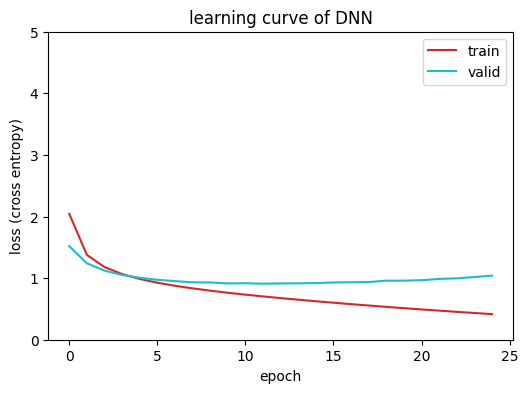

In [40]:
plot_learning_curve(model_loss_records, "DNN")

## Testing

In [41]:
model = Phoneme_Classifier(429, 39).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Prediction

In [42]:
predict = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1)

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [43]:
with open ('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))

## Reference
**This is a modification code from ML2021 HW2-1**
* Source: https://speech.ee.ntu.edu.tw/~hylee/ml/2021-spring.php